In [1]:
from imports import *

### Cargando datos temporales

In [2]:
# Leer el archivo Parquet
table_loaded = pq.read_table("6'_5ophits.parquet")

# Convertir de vuelta a Awkward Array o NumPy
input = ak.to_numpy(table_loaded["input"])
nuvT_c = ak.to_numpy(table_loaded["nuvT_c"])

print("Loaded matrix shape:", input.shape)  # Debería ser (21900, 400, 4)
print("Loaded vector shape:",nuvT_c.shape)  # Debería ser (21900,))
print("Matrix sample:\n", input[0, :3])
print("Vector sample:", nuvT_c[:3])

Loaded matrix shape: (21964, 20, 4)
Loaded vector shape: (21964,)
Matrix sample:
 [[1478.72460015   70.            0.            0.        ]
 [1480.72460015   16.            0.            0.        ]
 [1480.72460015   14.            0.            0.        ]]
Vector sample: [1462.42688725 1480.24647869  643.02543649]


### Cargando datos espaciales

In [3]:
image = np.load("/data/vidales/images/image_v1303_onlype.npy")

In [9]:
print(image.shape)

(21964, 59, 70, 8)


### Cargando etiquetas

In [4]:
table = pq.read_table('saved_archives/v1303_noTPCselection_c1&c2.parquet')
dEpromx = ak.from_iter(table.column('dEpromx').to_pylist())
dEpromy = ak.from_iter(table.column('dEpromy').to_pylist())
dEpromz = ak.from_iter(table.column('dEpromz').to_pylist())
del table

dEpromx = np.array(dEpromx).flatten()
dEpromy = np.array(dEpromy).flatten()
dEpromz = np.array(dEpromz).flatten()

dEpromx = dEpromx.reshape(-1, 1)
dEpromy = dEpromy.reshape(-1, 1)
dEpromz = dEpromz.reshape(-1, 1)

In [5]:
#y = np.column_stack((nuvT_c, dEpromx_f, dEpromy_f, dEpromz_f))
y = np.column_stack((nuvT_c, dEpromx, dEpromy, dEpromz))
y_np = ak.to_numpy(y)
print("Merged y_np:")
print(y_np)
print(np.shape(y_np))

Merged y_np:
[[1462.42688725 -141.81035117  140.83112553   74.82157564]
 [1480.24647869 -128.18496115  158.65734985  187.35995061]
 [ 643.02543649   89.7728596  -156.06595153  218.71311199]
 ...
 [ 891.94434413 -124.34233789   15.40607009  319.10272126]
 [ 514.17493045  122.74146747   88.72589418  287.34965045]
 [ 268.03104886   36.9916876    78.19434956  251.45103767]]
(21964, 4)


In [6]:
from sklearn.preprocessing import MinMaxScaler
# Define the column indices you want to scale to [0, 1] and [-1, 1]
# For 4 entries (t,x,y,z):

columns_0_to_1 = [0,3]  # For example, columns 0 and 2 to scale to [0, 1]
columns_minus1_to_1 = [1,2]  # For example, columns 1 and 3 to scale to [-1, 1]

# For 3 entries (x,y,z):

#columns_0_to_1 = [2]  # For example, columns 0 and 2 to scale to [0, 1]
#columns_minus1_to_1 = [0, 1]  # For example, columns 1 and 3 to scale to [-1, 1]

# Initialize two scalers
scaler_0_1 = MinMaxScaler(feature_range=(0, 1))
scaler_minus1_1 = MinMaxScaler(feature_range=(-1, 1))

# Apply scaling for columns that need [0, 1]
y_np_scaled_0_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_0_1[:, columns_0_to_1] = scaler_0_1.fit_transform(y_np[:, columns_0_to_1])

# Apply scaling for columns that need [-1, 1]
y_np_scaled_minus1_1 = np.copy(y_np)  # Make a copy to avoid modifying the original data
y_np_scaled_minus1_1[:, columns_minus1_to_1] = scaler_minus1_1.fit_transform(y_np[:, columns_minus1_to_1])

# Combine the results (scaled data)
y_scaled_combined = np.copy(y_np)  # Start with the original data
y_scaled_combined[:, columns_0_to_1] = y_np_scaled_0_1[:, columns_0_to_1]
y_scaled_combined[:, columns_minus1_to_1] = y_np_scaled_minus1_1[:, columns_minus1_to_1]

# Print the scaled data
print("Scaled Data (columns 0 and 3 -> scaled to [0, 1] and columns 1 and 2 -> scaled to [-1, 1]):")
print(y_scaled_combined)

Scaled Data (columns 0 and 3 -> scaled to [0, 1] and columns 1 and 2 -> scaled to [-1, 1]):
[[ 0.95919574 -0.70778976  0.69523988  0.13987098]
 [ 0.97086068 -0.63959104  0.7834291   0.36412399]
 [ 0.42280517  0.45134609 -0.77355807  0.42660082]
 ...
 [ 0.58575064 -0.62035768  0.0747418   0.62664522]
 [ 0.33845799  0.61636279  0.43746685  0.5633715 ]
 [ 0.17732909  0.18716222  0.3853656   0.49183704]]


In [7]:
test_size = int(np.floor(0.20*np.shape(y_np)[0]) )
print(test_size)

X_train_temp, X_test_temp = input[:-test_size], input[-test_size:]
print('x_train_temp dim.:',X_train_temp.shape)
print('x_test_temp dim.:', X_test_temp.shape)

X_train_esp, X_test_esp = image[:-test_size], image[-test_size:]
print('x_train_esp dim.:',X_train_esp.shape)
print('x_test_esp dim.:', X_test_esp.shape)

y_train, y_test = y_scaled_combined[:-test_size], y_scaled_combined[-test_size:]

4392
x_train_temp dim.: (17572, 20, 4)
x_test_temp dim.: (4392, 20, 4)
x_train_esp dim.: (17572, 59, 70, 8)
x_test_esp dim.: (4392, 59, 70, 8)


### Modelo

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2

# MaskNegative1000 Layer (from your original code)
class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs, mask

def combined_model(x_train_lstm, x_train_cnn):
    """
    Creates and returns a combined model with an LSTM network for temporal prediction
    and a CNN network for spatial prediction.

    Parameters:
    - x_train_lstm: Input data for the LSTM model (temporal data).
    - x_train_cnn: Input data for the CNN model (spatial data).
    
    Returns:
    - model: A compiled model.
    """
    # Define the LSTM model (Temporal prediction)
    inputs_lstm = Input(shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]))
    masked_inputs, mask = MaskNegative1000()(inputs_lstm)

    lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs, mask=mask)
    lstm_out2 = LSTM(128, return_sequences=False)(lstm_out1)

    x_lstm = Dense(64, kernel_regularizer=l2(0.01))(lstm_out2)
    x_lstm = LeakyReLU(alpha=0.1)(x_lstm)
    x_lstm = Dropout(0.3)(x_lstm)
    output_lstm = Dense(1)(x_lstm)  # Temporal output

    # Define the CNN model (Spatial prediction)
    inputs_cnn = Input(shape=(x_train_cnn.shape[1], x_train_cnn.shape[2], x_train_cnn.shape[3]))  # Adapt the input shape if needed
    model_cnn = Conv2D(32, (3, 3), padding='same')(inputs_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Conv2D(64, (3, 3), padding='same')(model_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Conv2D(128, (3, 3), padding='same')(model_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Conv2D(256, (3, 3), padding='same')(model_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Flatten()(model_cnn)
    model_cnn = Dense(1024, activation='relu')(model_cnn)
    model_cnn = Dropout(0.3)(model_cnn)
    model_cnn = Dense(512, activation='relu')(model_cnn)
    model_cnn = Dropout(0.3)(model_cnn)
    model_cnn = Dense(256, activation='relu')(model_cnn)
    model_cnn = Dropout(0.3)(model_cnn)
    model_cnn = Dense(128, activation='relu')(model_cnn)
    model_cnn = Dropout(0.3)(model_cnn)

    output_cnn = Dense(3, activation='linear')(model_cnn)  # Spatial output (3 coordinates)

    # Concatenate the outputs from LSTM and CNN models
    concatenated = layers.concatenate([output_lstm, output_cnn])

    # Define the fully connected layers
    fc = Dense(64, kernel_regularizer=l2(0.01))(concatenated)
 
    # Final output layer (total of 4 variables: 1 temporal + 3 spatial)
    final_output = Dense(4, activation='linear')(fc)

    # Create the combined model
    combined_model = Model(inputs=[inputs_lstm, inputs_cnn], outputs=final_output)

    # Compile the model
    combined_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    # Return the model
    return combined_model


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Attention
from tensorflow.keras.regularizers import l2

# MaskNegative1000 Layer (unchanged)
class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Crear la máscara booleana para valores distintos de -1000
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs * tf.expand_dims(tf.cast(mask, dtype=tf.float32), -1), mask
    
    def compute_mask(self, inputs, mask=None):
        return tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)

def combined_model_lstm_wattention_resnet(x_train_lstm, x_train_cnn):
    """
    Crea y retorna un modelo combinado con una red LSTM para predicción temporal
    y una red ResNet-18 para predicción espacial.

    Parámetros:
    - x_train_lstm: Datos de entrada para el modelo LSTM (datos temporales).
    - x_train_cnn: Datos de entrada para el modelo CNN (datos espaciales).
    
    Retorna:
    - model: El modelo compilado.
    """
    # Define el modelo LSTM (predicción temporal)
    inputs_lstm = Input(shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]))
    masked_inputs, mask = MaskNegative1000()(inputs_lstm)

    lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs, mask=mask)
    lstm_out2 = LSTM(128, return_sequences=True)(lstm_out1, mask=mask)
    lstm_out3 = LSTM(64, return_sequences=True)(lstm_out2, mask=mask)

    # Atención sobre sí mismo (self-attention)
    attn_out = Attention()([lstm_out3, lstm_out3])

    lstm_out4 = LSTM(32, return_sequences=False)(attn_out, mask=mask)

    x_lstm = Dense(64, kernel_regularizer=l2(0.01))(lstm_out4)
    x_lstm = LeakyReLU(alpha=0.1)(x_lstm)
    x_lstm = Dropout(0.3)(x_lstm)
    output_lstm = Dense(1)(x_lstm)  # Salida temporal

    # Define el modelo ResNet-18 (predicción espacial)
    inputs_cnn = Input(shape=(x_train_cnn.shape[1], x_train_cnn.shape[2], x_train_cnn.shape[3]))  # e.g., (57, 60, 16)

    # Capa de convolución inicial
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs_cnn)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Bloque residual básico
    def basic_block(input, filters, stride=1, downsample=False):
        shortcut = input

        # Primera convolución en el bloque
        x = Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(input)
        x = BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Segunda convolución en el bloque
        x = Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)

        # Hacer downsampling al atajo si es necesario
        if downsample:
            shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(input)
            shortcut = BatchNormalization()(shortcut)

        # Añadir el atajo al camino principal
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
        return x

    # Etapas de ResNet-18
    x = basic_block(x, 64)
    x = basic_block(x, 64)

    x = basic_block(x, 128, stride=2, downsample=True)
    x = basic_block(x, 128)

    x = basic_block(x, 256, stride=1, downsample=True)
    x = basic_block(x, 256)

    x = basic_block(x, 512, stride=1, downsample=True)
    x = basic_block(x, 512)

    # Promediado global
    x = layers.GlobalAveragePooling2D()(x)

    # Capa de Dropout y capa Dense para salida espacial
    x = Dropout(0.4)(x)
    output_cnn = Dense(3, activation='linear')(x)  # Salida espacial (3 coordenadas)

    # Concatenar las salidas del modelo LSTM y CNN
    concatenated = layers.concatenate([output_lstm, output_cnn])

    # Capas completamente conectadas
    fc = Dense(64, kernel_regularizer=l2(0.01))(concatenated)
    final_output = Dense(4, activation='linear')(fc)  # Salida total (4 variables: 1 temporal + 3 espaciales)

    # Crear el modelo combinado
    combined_model = Model(inputs=[inputs_lstm, inputs_cnn], outputs=final_output)

    # Compilar el modelo
    combined_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    # Retornar el modelo
    return combined_model

# Ejemplo de uso:
# Supón que x_train_lstm y x_train_cnn son tus datos de entrenamiento
# x_train_lstm = np.random.rand(32, 10, 50)  # Ejemplo: batch_size=32, timesteps=10, features=50
# x_train_cnn = np.random.rand(32, 57, 60, 16)  # Ejemplo: batch_size=32, 57x60x16
# model = combined_model_lstm_resnet(x_train_lstm, x_train_cnn)
# model.summary()


In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2

# MaskNegative1000 Layer (unchanged)
class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs, mask

def combined_model_resnet(x_train_lstm, x_train_cnn):
    """
    Creates and returns a combined model with an LSTM network for temporal prediction
    and a ResNet-18 network for spatial prediction.

    Parameters:
    - x_train_lstm: Input data for the LSTM model (temporal data).
    - x_train_cnn: Input data for the CNN model (spatial data).
    
    Returns:
    - model: A compiled model.
    """
    # Define the LSTM model (Temporal prediction) - unchanged
    inputs_lstm = Input(shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]))
    masked_inputs, mask = MaskNegative1000()(inputs_lstm)

    lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs, mask=mask)
    lstm_out2 = LSTM(128, return_sequences=False)(lstm_out1)

    x_lstm = Dense(64, kernel_regularizer=l2(0.01))(lstm_out2)
    x_lstm = LeakyReLU(alpha=0.1)(x_lstm)
    x_lstm = Dropout(0.3)(x_lstm)
    output_lstm = Dense(1)(x_lstm)  # Temporal output

    # Define the ResNet-18 model (Spatial prediction)
    inputs_cnn = Input(shape=(x_train_cnn.shape[1], x_train_cnn.shape[2], x_train_cnn.shape[3]))  # e.g., (57, 60, 16)

    # Initial convolution layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs_cnn)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Define the basic residual block
    def basic_block(input, filters, stride=1, downsample=False):
        shortcut = input

        # First convolution in the block
        x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(input)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Second convolution in the block
        x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)

        # Downsample the shortcut if needed
        if downsample:
            shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(input)
            shortcut = layers.BatchNormalization()(shortcut)

        # Add shortcut to the main path
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
        return x

    # ResNet-18 stages
    # Stage 1: 2 blocks with 64 filters
    x = basic_block(x, 64)
    x = basic_block(x, 64)

    # Stage 2: 2 blocks with 128 filters
    x = basic_block(x, 128, stride=2, downsample=True)
    x = basic_block(x, 128)

    # Stage 3: 2 blocks with 256 filters
    x = basic_block(x, 256, stride=1, downsample=True)  # Adjusted stride for smaller input
    x = basic_block(x, 256)

    # Stage 4: 2 blocks with 512 filters
    x = basic_block(x, 512, stride=1, downsample=True)  # Adjusted stride for smaller input
    x = basic_block(x, 512)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dropout and Dense layer for spatial output
    x = layers.Dropout(0.4)(x)
    output_cnn = layers.Dense(3, activation='linear')(x)  # Spatial output (3 coordinates)

    # Concatenate the outputs from LSTM and CNN models
    concatenated = layers.concatenate([output_lstm, output_cnn])

    # Define the fully connected layers
    fc = Dense(64, kernel_regularizer=l2(0.01))(concatenated)
 
    # Final output layer (total of 4 variables: 1 temporal + 3 spatial)
    final_output = Dense(4, activation='linear')(fc)

    # Create the combined model
    combined_model = Model(inputs=[inputs_lstm, inputs_cnn], outputs=final_output)

    # Compile the model
    combined_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    # Return the model
    return combined_model

# Example usage:
# Assuming x_train_lstm and x_train_cnn are your training data
# x_train_lstm = np.random.rand(32, 10, 50)  # Example: batch_size=32, timesteps=10, features=50
# x_train_cnn = np.random.rand(32, 57, 60, 16)  # Example: batch_size=32, 57x60x16
# model = combined_model_resnet(x_train_lstm, x_train_cnn)
# model.summary()

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Layer, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2

# MaskNegative1000 Layer
class MaskNegative1000(Layer):
    def __init__(self, **kwargs):
        super(MaskNegative1000, self).__init__(**kwargs)
    
    def call(self, inputs):
        mask = tf.reduce_any(inputs != tf.constant(-1000.0, dtype=tf.float32), axis=-1)
        return inputs, mask

def combined_model_merged_after(x_train_lstm, x_train_cnn):
    """
    Creates and returns a combined model with an LSTM network for temporal prediction
    and a CNN network for spatial prediction.

    Parameters:
    - x_train_lstm: Input data for the LSTM model (temporal data).
    - x_train_cnn: Input data for the CNN model (spatial data).
    
    Returns:
    - model: A compiled model.
    """
    # Define the LSTM model (Temporal feature extraction)
    inputs_lstm = Input(shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]))
    masked_inputs, mask = MaskNegative1000()(inputs_lstm)

    lstm_out1 = LSTM(256, return_sequences=True)(masked_inputs, mask=mask)
    lstm_out2 = LSTM(128, return_sequences=False)(lstm_out1)

    # Define the CNN model (Spatial feature extraction)
    inputs_cnn = Input(shape=(x_train_cnn.shape[1], x_train_cnn.shape[2], x_train_cnn.shape[3]))  # Adapt the input shape if needed
    model_cnn = Conv2D(32, (3, 3), padding='same')(inputs_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Conv2D(64, (3, 3), padding='same')(model_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Conv2D(128, (3, 3), padding='same')(model_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Conv2D(256, (3, 3), padding='same')(model_cnn)
    model_cnn = BatchNormalization()(model_cnn)
    model_cnn = LeakyReLU(alpha=0.1)(model_cnn)
    model_cnn = MaxPooling2D((2, 2), padding='same')(model_cnn)

    model_cnn = Flatten()(model_cnn)

    # Concatenate the outputs from LSTM and CNN models
    merged = layers.concatenate([lstm_out2, model_cnn])

    # Fully connected layers after concatenation
    fc = Dense(512, kernel_regularizer=l2(0.01))(merged)
    fc = LeakyReLU(alpha=0.1)(fc)
    fc = Dropout(0.3)(fc)

    fc = Dense(256, kernel_regularizer=l2(0.01))(fc)
    fc = LeakyReLU(alpha=0.1)(fc)
    fc = Dropout(0.3)(fc)

    fc = Dense(128, kernel_regularizer=l2(0.01))(fc)
    fc = LeakyReLU(alpha=0.1)(fc)
    fc = Dropout(0.3)(fc)

    # Final output layer (total of 4 variables: 1 temporal + 3 espaciales)
    final_output = Dense(4, activation='linear')(fc)

    # Create the combined model
    combined_model = Model(inputs=[inputs_lstm, inputs_cnn], outputs=final_output)

    # Compile the model
    combined_model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    return combined_model


### Creación modelo

In [ ]:
model = combined_model(X_train_temp, X_train_esp)
model.summary()

In [42]:
model33 = combined_model_resnet(X_train_temp, X_train_esp)
model33.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 59, 70, 8)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 30, 35, 64)   25088       ['input_8[0][0]']                
                                                                                                  
 batch_normalization_28 (BatchN  (None, 30, 35, 64)  256         ['conv2d_28[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_17 (ReLU)                (None, 30, 35, 64)   0           ['batch_normalization_28[0]

In [9]:
model100 = combined_model_lstm_wattention_resnet(X_train_temp, X_train_esp)
model100.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 59, 70, 8)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 35, 64)   25088       ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 30, 35, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 30, 35, 64)   0           ['batch_normalization[0][0]']

In [11]:
y_pred, history= train_and_predict(model100, (X_train_temp, X_train_esp), y_train, (X_test_temp, X_test_esp), y_test, epochs=80, batch_size=16)

Epoch 1/80


2025-03-28 18:35:08.455047: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-SXM2-16GB" frequency: 1480 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8201" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16128933888 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1099/1099 [==============================] - ETA: 0s - loss: 0.1185 - mse: 0.0424

2025-03-28 18:35:51.839569: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-SXM2-16GB" frequency: 1480 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8201" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16128933888 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
/opt/anaconda3/envs/ROOT_TF/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1099/1099 [==============================] - 60s 39ms/step - loss: 0.1185 - mse: 0.0424 - val_loss: 0.0410 - val_mse: 0.0141 - lr: 0.0010
Epoch 2/80
1099/1099 [==============================] - 36s 33ms/step - loss: 0.0330 - mse: 0.0161 - val_loss: 0.0220 - val_mse: 0.0125 - lr: 0.0010
Epoch 3/80
1099/1099 [==============================] - 37s 33ms/step - loss: 0.0188 - mse: 0.0132 - val_loss: 0.0156 - val_mse: 0.0125 - lr: 0.0010
Epoch 4/80
1099/1099 [==============================] - 36s 33ms/step - loss: 0.0142 - mse: 0.0122 - val_loss: 0.0166 - val_mse: 0.0154 - lr: 0.0010
Epoch 5/80
1099/1099 [==============================] - 36s 33ms/step - loss: 0.0122 - mse: 0.0112 - val_loss: 0.0131 - val_mse: 0.0122 - lr: 0.0010
Epoch 6/80
1099/1099 [==============================] - 36s 33ms/step - loss: 0.0116 - mse: 0.0108 - val_loss: 0.0097 - val_mse: 0.0089 - lr: 0.0010
Epoch 7/80
1099/1099 [==============================] - 36s 33ms/step - loss: 0.0109 - mse: 0.0102 - val_loss: 0.0110

2025-03-28 18:57:36.248261: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-SXM2-16GB" frequency: 1480 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8201" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16128933888 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


### Resultados

In [12]:
# Initialize a copy of the scaled combined data
y_pred_inverse= np.copy(y_pred)
y_test_inverse= np.copy(y_test)

# Inverse scaling for columns scaled to [0, 1]
y_pred_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_pred[:, columns_0_to_1])
y_test_inverse[:, columns_0_to_1] = scaler_0_1.inverse_transform(y_test[:, columns_0_to_1])

# Inverse scaling for columns scaled to [-1, 1]
y_pred_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_pred[:, columns_minus1_to_1])
y_test_inverse[:, columns_minus1_to_1] = scaler_minus1_1.inverse_transform(y_test[:, columns_minus1_to_1])

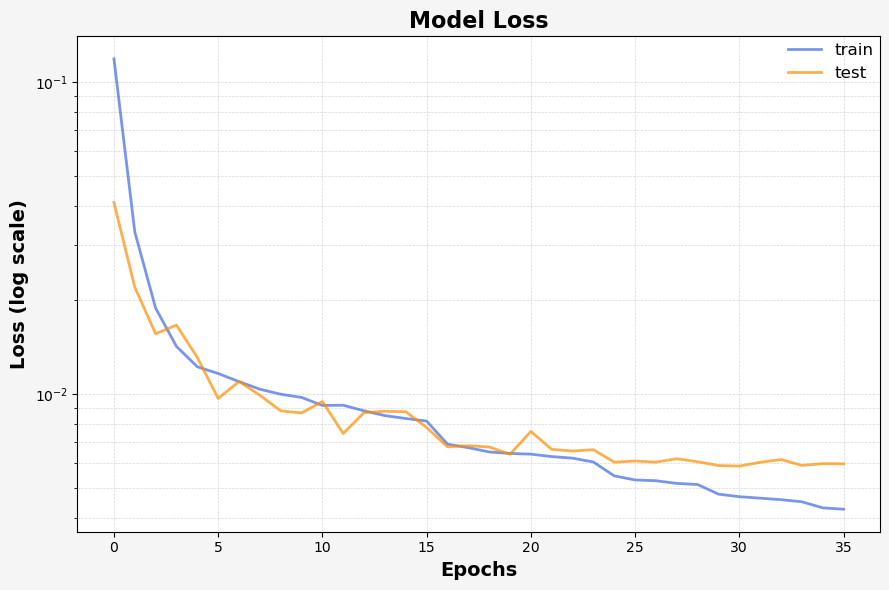

In [13]:
import matplotlib.pyplot as plt

# Access each model's history
model_history = history.history


# Plotting the validation loss for all models
plt.figure(figsize=(9, 6))

# Plot each model's validation loss with smoother lines, subtle markers, and clearer styling
# Training curves (using shades of blue and green)
plt.plot(model_history['loss'], label='train', color='royalblue', linestyle='-', markersize=6, alpha=0.7, linewidth=2)


# Testing curves (using shades of orange and red)
plt.plot(model_history['val_loss'], label='test', color='darkorange', linestyle='-', markersize=6, alpha=0.7, linewidth=2)


# Enhance plot appearance
plt.yscale('log')  # Use logarithmic scale on y-axis
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss (log scale)', fontsize=14, fontweight='bold')
plt.title('Model Loss', fontsize=16, fontweight='bold')

# Refined grid with lighter lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Add legend with better positioning and larger font
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., frameon=False)

# Add background color for plot to make it stand out
plt.gcf().set_facecolor('whitesmoke')

# Show plot with a tight layout to avoid clipping
plt.tight_layout()
plt.show()


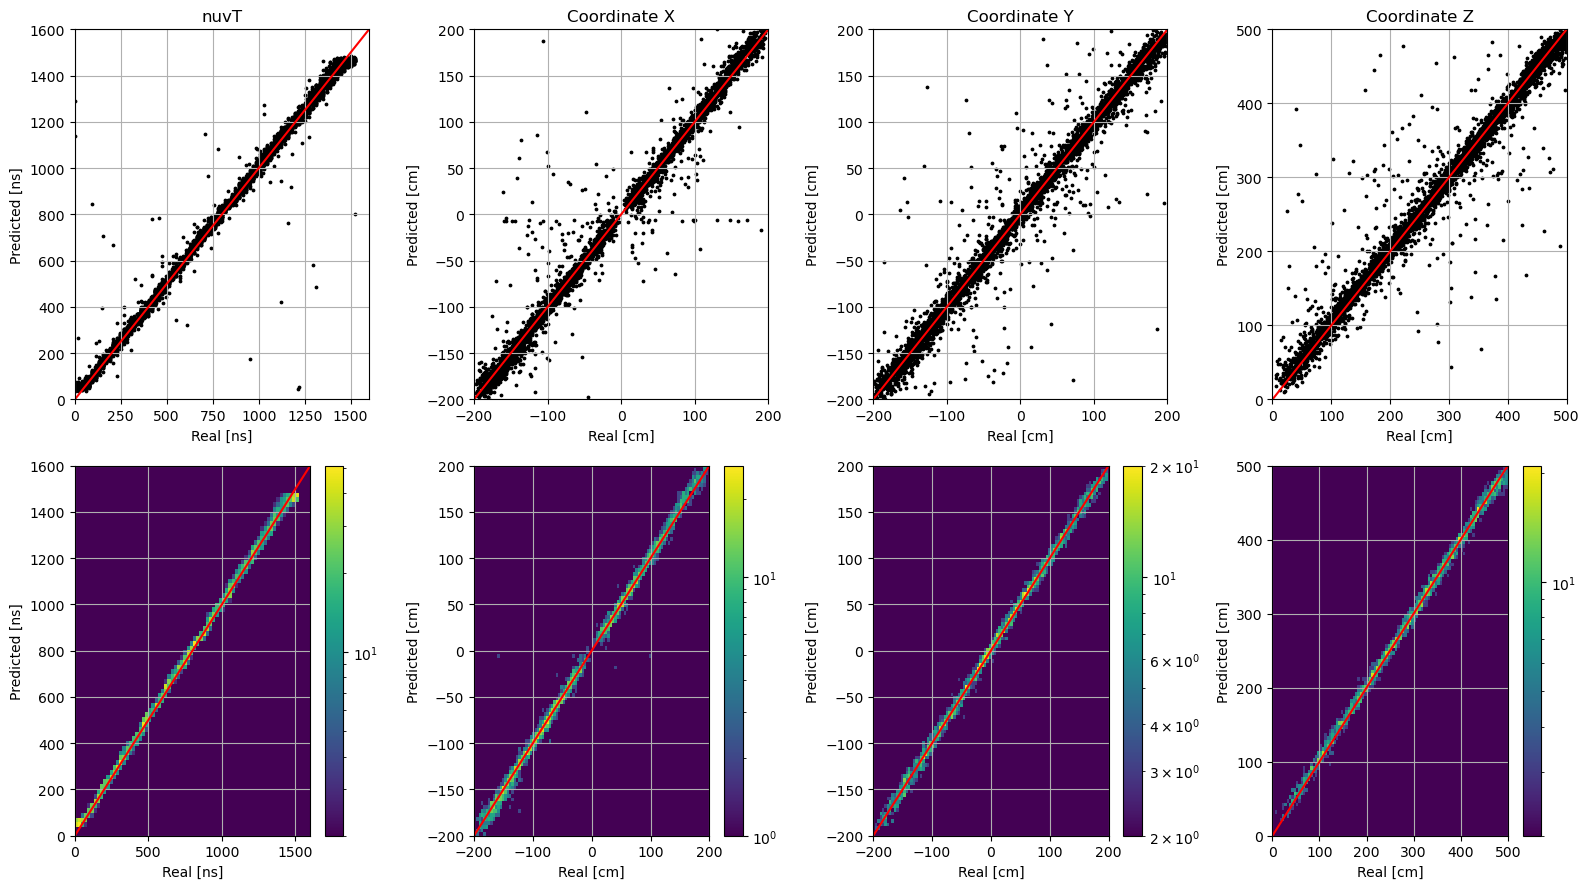

In [14]:
import matplotlib.colors as mcolors
fig, axs = plt.subplots(2,4,figsize=(16,9))

axs[0,0].scatter(y_test_inverse[:,0], y_pred_inverse[:,0], color="black",s=3)
axs[0,0].grid()

axs[0,0].plot([0,1600],[0,1600],color="r")
axs[0,0].title.set_text('nuvT')
axs[0,0].set_xlim([0,1600])
axs[0,0].set_ylim([0,1600])
axs[0,0].set_ylabel('Predicted [ns]')
axs[0,0].set_xlabel('Real [ns]')

im0 = axs[1,0].hist2d(y_test_inverse[:,0], y_pred_inverse[:,0].flatten(), bins=(70, 70), cmap='viridis', cmin=2, norm=mcolors.LogNorm())
fig.colorbar(im0[3], ax=axs[1,0])
axs[1,0].grid()

axs[1,0].plot([0,1600],[0,1600],'r')
axs[1,0].set_xlim([0,1600])
axs[1,0].set_ylim([0,1600])
axs[1,0].set_ylabel('Predicted [ns]')
axs[1,0].set_xlabel('Real [ns]')
axs[1,0].set_facecolor('#440154')


axs[0,1].scatter(y_test_inverse[:,1], y_pred_inverse[:,1], color="black",s=3)
axs[0,1].grid()

axs[0,1].plot([-200,200],[-200,200],color="r")
axs[0,1].title.set_text('Coordinate X')
axs[0,1].set_xlim([-200,200])
axs[0,1].set_ylim([-200,200])
axs[0,1].set_ylabel('Predicted [cm]')
axs[0,1].set_xlabel('Real [cm]')


im1 = axs[1,1].hist2d(y_test_inverse[:,1], y_pred_inverse[:,1].flatten(), bins=(100, 100), cmap='viridis', cmin=0,cmax=30, norm=mcolors.LogNorm())
fig.colorbar(im1[3], ax=axs[1,1])
axs[1,1].grid()

axs[1,1].plot([-200,200],[-200,200],'r')
axs[1,1].set_xlim([-200,200])
axs[1,1].set_ylim([-200,200])
axs[1,1].set_ylabel('Predicted [cm]')
axs[1,1].set_xlabel('Real [cm]')
axs[1,1].set_facecolor('#440154')


axs[0,2].scatter(y_test_inverse[:,2], y_pred_inverse[:,2], color="black",s=3)
axs[0,2].grid()

axs[0,2].plot([-200,200],[-200,200],color="r")
axs[0,2].title.set_text('Coordinate Y')
axs[0,2].set_xlim([-200,200])
axs[0,2].set_ylim([-200,200])
axs[0,2].set_ylabel('Predicted [cm]')
axs[0,2].set_xlabel('Real [cm]')


im2 = axs[1,2].hist2d(y_test_inverse[:,2], y_pred_inverse[:,2].flatten(), bins=(100, 100), cmap='viridis',cmin=2, cmax=30, norm=mcolors.LogNorm())
fig.colorbar(im2[3], ax=axs[1,2])
axs[1,2].grid()

axs[1,2].plot([-200,200],[-200,200],'r')
axs[1,2].set_xlim([-200,200])
axs[1,2].set_ylim([-200,200])
axs[1,2].set_ylabel('Predicted [cm]')
axs[1,2].set_xlabel('Real [cm]')
axs[1,2].set_facecolor('#440154')


axs[0,3].scatter(y_test_inverse[:,3], y_pred_inverse[:,3], color="black",s=3)
axs[0,3].grid()

axs[0,3].plot([0,500],[0,500],color="r")
axs[0,3].title.set_text('Coordinate Z')
axs[0,3].set_xlim([0,500])
axs[0,3].set_ylim([0,500])
axs[0,3].set_ylabel('Predicted [cm]')
axs[0,3].set_xlabel('Real [cm]')


im3 = axs[1,3].hist2d(y_test_inverse[:,3], y_pred_inverse[:,3].flatten(), bins=(100, 100), cmap='viridis',cmin=2, cmax=30, norm=mcolors.LogNorm())
fig.colorbar(im3[3], ax=axs[1,3])
axs[1,3].grid()

axs[1,3].set_xlim([0,500])
axs[1,3].set_ylim([0,500])
axs[1,3].plot([0,500],[0,500], 'r')
axs[1,3].set_ylabel('Predicted [cm]')
axs[1,3].set_xlabel('Real [cm]')
axs[1,3].set_facecolor('#440154')

fig.tight_layout()

plt.show()
#plt.savefig('/tmp/...', dpi=300)

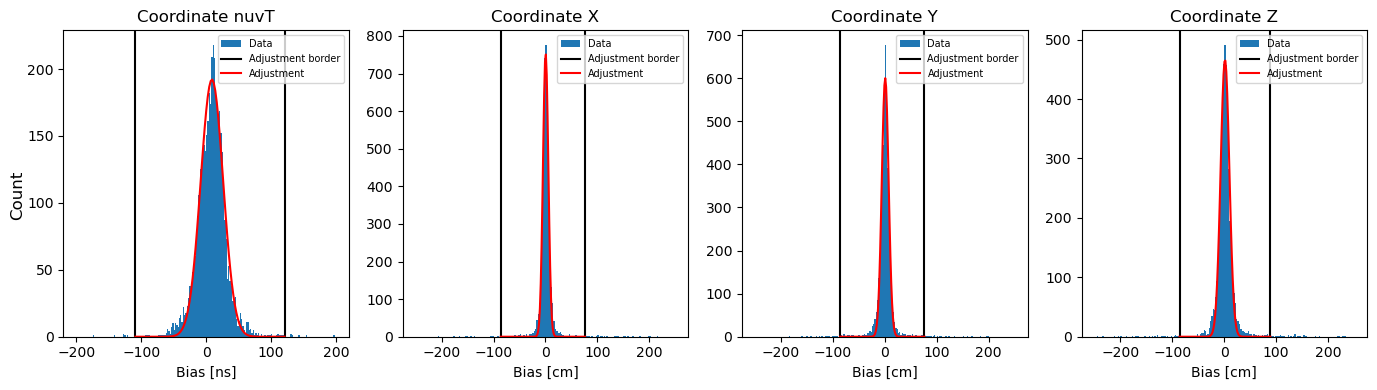

Bias Adjustment variables
------------------
Mean nuvT = 9.02
Sigma nuvT = 17.30
------------------
Mean X = 0.35
Sigma X = 5.17
------------------
Mean Y = 0.66
Sigma Y = 6.55
------------------
Mean Z = 1.40
Sigma Z = 8.39
------------------


In [15]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculating the differences between the prediction and the real value
diffnuvT = y_pred_inverse[:, 0].flatten() - y_test_inverse[:, 0]
diffX = y_pred_inverse[:, 1].flatten() - y_test_inverse[:, 1]
diffY = y_pred_inverse[:, 2].flatten() - y_test_inverse[:, 2]
diffZ = y_pred_inverse[:, 3].flatten() - y_test_inverse[:, 3]

# Create subplots for each coordinate
fig, axs = plt.subplots(1, 4, figsize=(14, 4))

# Updated fit_and_plot_hist for nuvT with range [-400, 400]
def fit_and_plot_hist(diff, axs, index, coord_name, ini, fin, hist_range):
    counts, bins, patches = axs[index].hist(diff, 200, range=hist_range, label='Data')
    step = (bins[1] - bins[0]) / 2
    bin_centers = bins[:-1] + step

    # Ensure the fit range is within the histogram bounds
    ini = max(0, min(ini, len(bin_centers) - 1))
    fin = max(ini + 1, min(fin, len(bin_centers) - 1))

    axs[index].axvline(x=bin_centers[ini], color='k', label='Adjustment border')
    axs[index].axvline(x=bin_centers[fin], color='k')

    # Gaussian Fit for the data
    p0 = [np.max(counts), 0, 50]  # Amplitude, mean, sigma (adjust based on your data)
    popt, _ = curve_fit(func, bin_centers[ini:fin+1], counts[ini:fin+1], p0=p0, bounds=([0, -np.inf, 0], [np.inf, np.inf, np.inf]))
    ym = func(np.linspace(bin_centers[ini], bin_centers[fin], 100), *popt)
    axs[index].plot(np.linspace(bin_centers[ini], bin_centers[fin], 100), ym, c='r', label='Adjustment')

    axs[index].set_xlabel('Bias [cm]' if coord_name != 'nuvT' else 'Bias [ns]')  # Set different xlabel for nuvT
    axs[index].set_title(f'Coordinate {coord_name}')
    axs[index].legend(prop={"size": 7})

    return popt

# Call the function with updated range for nuvT
popt_nuvT = fit_and_plot_hist(diffnuvT, axs, 0, 'nuvT', 45, 160, hist_range=[-200, 200])
popt_X = fit_and_plot_hist(diffX, axs, 1, 'X', 65, 130, hist_range=[-250, 250])
popt_Y = fit_and_plot_hist(diffY, axs, 2, 'Y', 65, 130, hist_range=[-250, 250])
popt_Z = fit_and_plot_hist(diffZ, axs, 3, 'Z', 65, 135, hist_range=[-250, 250])


# Adjust layout
fig.supylabel('Count')
fig.tight_layout()

# Show the plot
plt.show()

# Print adjustment variables
print('Bias Adjustment variables')
print('------------------')
print(f'Mean nuvT = {popt_nuvT[1]:.2f}')
print(f'Sigma nuvT = {popt_nuvT[2]:.2f}')
print('------------------')
print(f'Mean X = {popt_X[1]:.2f}')
print(f'Sigma X = {popt_X[2]:.2f}')
print('------------------')
print(f'Mean Y = {popt_Y[1]:.2f}')
print(f'Sigma Y = {popt_Y[2]:.2f}')
print('------------------')
print(f'Mean Z = {popt_Z[1]:.2f}')
print(f'Sigma Z = {popt_Z[2]:.2f}')
print('------------------')


In [49]:
# Print adjustment variables
print('Precision Adjustment variables')
print('------------------')
print(f'Sigma nuvT = {(1 - popt_nuvT[2] / (np.max(y_test_inverse[:, 0]) - np.min(y_test_inverse[:, 0]))) * 100:.2f}%')
print('------------------')
print(f'Sigma X = {(1 - popt_X[2] / (np.max(y_test_inverse[:, 1]) - np.min(y_test_inverse[:, 1]))) * 100:.2f}%')
print('------------------')
print(f'Sigma Y = {(1 - popt_Y[2] / (np.max(y_test_inverse[:, 2]) - np.min(y_test_inverse[:, 2]))) * 100:.2f}%')
print('------------------')
print(f'Sigma Z = {(1 - popt_Z[2] / (np.max(y_test_inverse[:, 1]) - np.min(y_test_inverse[:, 1]))) * 100:.2f}%')
print('------------------')

Precision Adjustment variables
------------------
Sigma nuvT = 99.24%
------------------
Sigma X = 98.73%
------------------
Sigma Y = 98.30%
------------------
Sigma Z = 97.84%
------------------
